<a href="https://colab.research.google.com/github/nathanzilgo/Audio-Processing/blob/fine-tune/music_generation_LSTM%20documented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Este notebook tem como objetivo treinar uma rede neural LSTM para geração de músicas curtas, baseadas em base de dados de compositores no formato MIDI

In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 16 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5,420 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [

Para poder sintetizar MIDI para WAV e testar os outputs:

In [2]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Para trabalhar com MIDI:

In [3]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 5.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=65971dddb93de958d24e35f226d95ca11f6ac080916bb0d607ad171682ab98de
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


## Libs:

In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [5]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Dataset de treinamento:
Utilizando composições em MIDI do Chopin

investigar e testar esse aqui tb:
http://www.piano-midi.de/

In [6]:
chopin_dir = pathlib.Path('data/chopinMidi')
chopin_origin = 'http://www.piano-midi.de/zip/chopin.zip'
chopin_fname = 'chopin.zip'
# maestro_origin = 'https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip'
# maestro_dir = pathlib.Path('data/maestro-v2.0.0')

In [7]:

if not chopin_dir.exists():
  tf.keras.utils.get_file(
      chopin_fname,
      origin= chopin_origin,
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

315789/315789 [==============================] - 0s 1us/step


In [8]:
filenames = glob.glob(str('data/*.mid*'))
print('Number of files:', len(filenames))


Number of files: 48


In [10]:
import random
random_index = random.randint(0, len(filenames)-1)

sample_file = filenames[random_index]
print(sample_file)

data/chpn_op25_e3.mid


In [11]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [12]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

Testa um dos arquivos MIDI do dataset:

In [13]:
display_audio(pm)

Identificação de instrumentos:

In [14]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

for x in pm.instruments:
  print(pretty_midi.program_to_instrument_name(x.program))

Number of instruments: 2
Instrument name: Acoustic Grand Piano
Acoustic Grand Piano
Acoustic Grand Piano


Identificação das notas e duração:

In [15]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=72, note_name=C5, duration=0.4145
1: pitch=74, note_name=D5, duration=0.0970
2: pitch=65, note_name=F4, duration=0.2087
3: pitch=77, note_name=F5, duration=0.1116
4: pitch=72, note_name=C5, duration=0.2232
5: pitch=67, note_name=G4, duration=0.0970
6: pitch=60, note_name=C4, duration=0.2067
7: pitch=72, note_name=C5, duration=0.1096
8: pitch=65, note_name=F4, duration=0.2192
9: pitch=74, note_name=D5, duration=0.0970


In [16]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

Notas do arquivo de teste mais detalhadas, com afinação, inicio, fim, tempo (bar) e duração:

In [17]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,72,0.829016,1.243524,0.000000,0.414508
1,74,1.243524,1.340574,0.414508,0.097050
2,65,1.243524,1.452189,0.000000,0.208665
3,72,1.340574,1.563805,0.097050,0.223231
4,77,1.452189,1.563805,0.111616,0.111615


Nome das notas presentes no sample de teste:

In [18]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C5', 'D5', 'F4', 'C5', 'F5', 'G4', 'C4', 'F4', 'C5', 'D5'],
      dtype='<U3')

Plota um gráfico das notas, duração e step em uma linha temporal de piano:

In [19]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

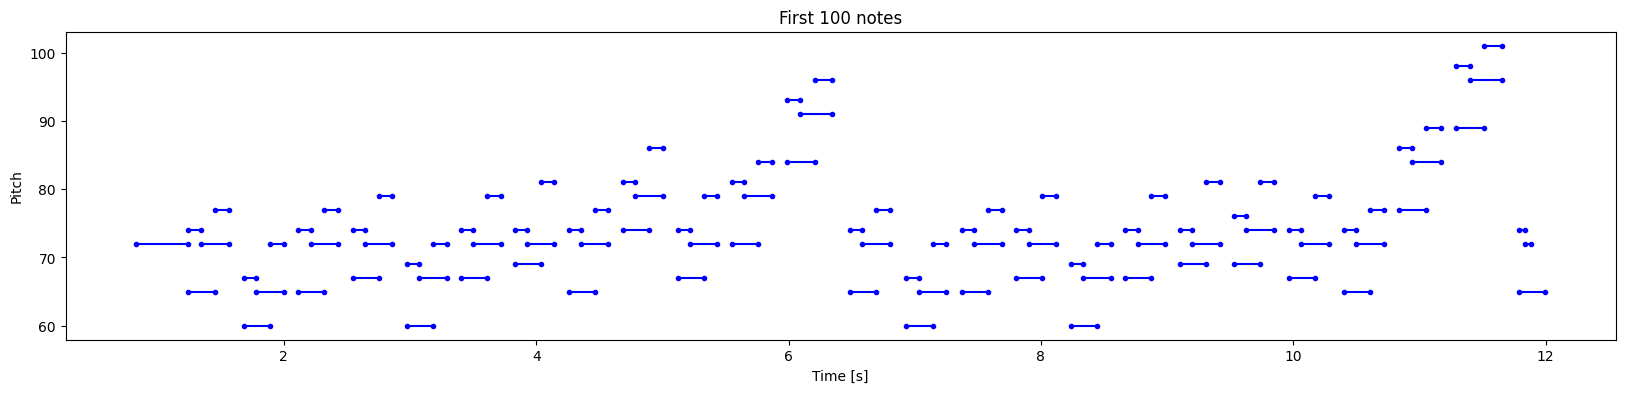

In [20]:
plot_piano_roll(raw_notes, count=100)

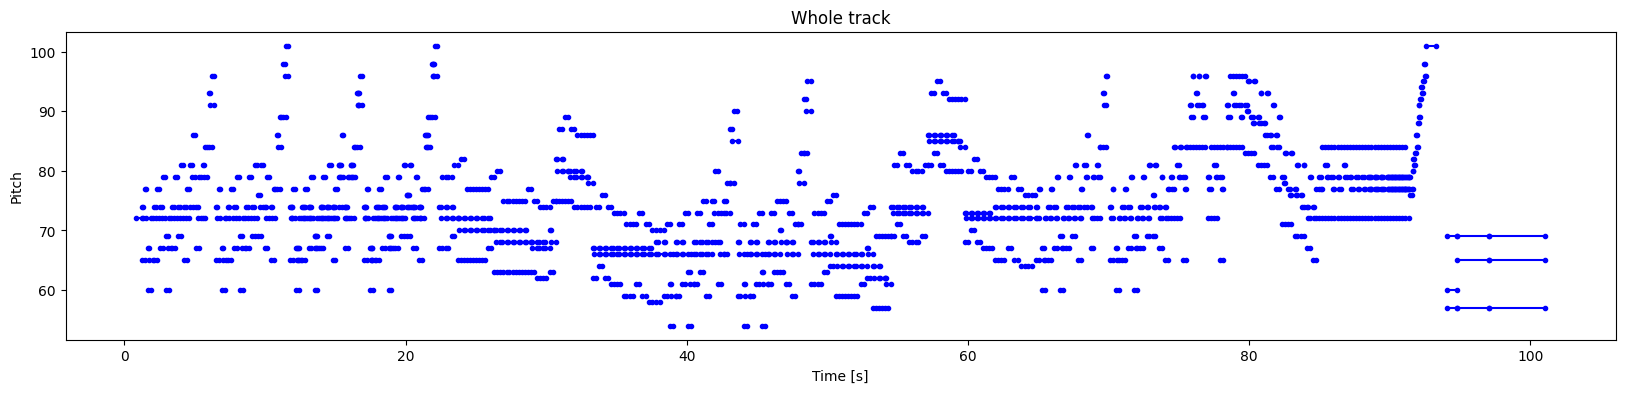

In [21]:
plot_piano_roll(raw_notes)

Plota a distribuição de frequencia das notas:

In [22]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

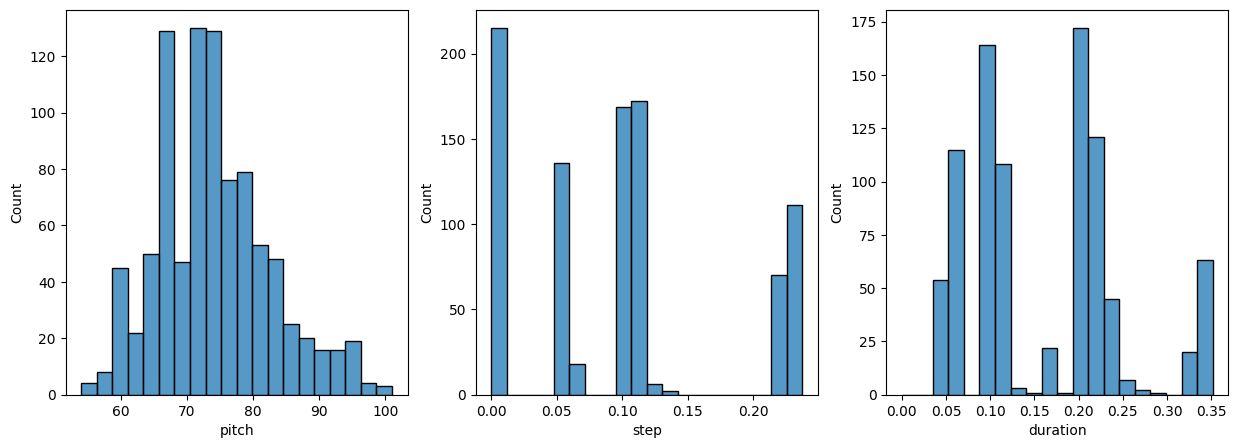

In [23]:
plot_distributions(raw_notes)

In [24]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [25]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [26]:
display_audio(example_pm)

Definição do número de notas que serão utilizadas no treino com o dataset:

In [27]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [28]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 3265


## Criação de DataSet das notas processadas:

In [29]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [30]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [34]:
!pip install keras_tuner
from keras_tuner import HyperParameters

hp = HyperParameters()
seq_length = hp.Int('seq_length', min_value=20, max_value=100, step=3)

def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.9 MB/s eta 0:00:00


Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use hyperparameter tuning. The size of the vocabulary (vocab_size) is set to 128 representing all the pitches supported by pretty_midi.



In [35]:
hp = HyperParameters()
vocab_size = 128

seq_ds = create_sequences(notes_ds, seq_length) # call this function after the model being trained
seq_ds.element_spec

(TensorSpec(shape=(20, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [36]:
# for seq, target in seq_ds.take(1):
#   print('sequence shape:', seq.shape)
#   print('sequence elements (first 10):', seq[0: 10])
#   print()
#   print('target:', target)

In [37]:
# batch_size = 64
# buffer_size = n_notes - seq_length  # the number of items in the dataset
# train_ds = (seq_ds
#             .shuffle(buffer_size)
#             .batch(batch_size, drop_remainder=True)
#             .cache()
#             .prefetch(tf.data.experimental.AUTOTUNE))

In [38]:
# train_ds.element_spec

## Treino do modelo:

In [39]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [40]:
def build_model(hp, seq_length=20):
  input_shape = (seq_length, 3)
  learning_rate = 0.005

  inputs = tf.keras.Input(input_shape)
  x = tf.keras.layers.LSTM(128)(inputs)

  outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
  }

  model = tf.keras.Model(inputs, outputs)

  loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
  }

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Get the list of trainable variables in your model
  trainable_vars = model.trainable_variables
# Build the optimizer with the trainable variables
  optimizer.build(trainable_vars)

  model.compile(loss=loss, optimizer=optimizer)

  return model

#model = build_model(hp)
#model.summary()

In [41]:
from keras_tuner import BayesianOptimization

tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='myDir'
)

tuner.search_space_summary()

Search space summary
Default search space size: 0


In [42]:
tuner.search(notes_ds, epochs=20)

Trial 1 Complete [00h 00m 01s]

Best val_loss So Far: None
Total elapsed time: 00h 00m 01s


In [44]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_seq_length = best_hyperparameters.get('seq_length')

KeyError: ignored

In [ ]:
best_seq_length

In [ ]:
seq_ds = create_sequences(notes_ds, best_seq_length) # call this function after the model being trained
seq_ds.element_spec

In [ ]:
batch_size = 64
buffer_size = n_notes - best_seq_length  # the number of items in the dataset (change this to get the best hp)
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
model = build_model(hp, best_seq_length)
model.summary()

Testing the model.evaluate function, you can see that the pitch loss is significantly greater than the step and duration losses. Note that loss is the total loss computed by summing all the other losses and is currently dominated by the pitch loss.

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 60

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    keras_model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes.head(10)

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
plot_piano_roll(generated_notes)

In [ ]:
plot_distributions(generated_notes)